In [1]:
pip install tensorflow[and-cuda]

zsh:1: no matches found: tensorflow[and-cuda]


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing the dependencies 
import math
import pandas as pd  
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt 
import matplotlib
from sklearn. preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout 
from sklearn. model_selection import TimeSeriesSplit 
from sklearn. metrics import mean_squared_error, r2_score 
import matplotlib. dates as mandates 
from sklearn.preprocessing import MinMaxScaler 
from sklearn import linear_model 
from keras.models import Sequential 
from keras. layers import Dense 
import keras. backend as K
from keras.callbacks import EarlyStopping 
from keras.optimizers import Adam 
from keras .models import load_model 
from keras. layers import LSTM 
from keras.utils import plot_model

2023-12-12 21:44:40.422056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# File to load
tesla_data_to_load =("TSLA_HData_5y.csv")

# Read file and store into Pandas dataframe
df = pd.read_csv(tesla_data_to_load)
df

,Name,Date,Open,High,Low,Close,Adj Close,Volume
0,TSLA,12/11/18,24.660667,24.811333,24.015333,24.450666,24.450666,94632000
1,TSLA,12/12/18,24.628000,24.794001,24.344000,24.440001,24.440001,75405000
2,TSLA,12/13/18,24.676666,25.162666,24.450001,25.119333,25.119333,110488500
3,TSLA,12/14/18,25.000000,25.191334,24.288668,24.380667,24.380667,95064000
4,TSLA,12/17/18,24.133333,24.379999,22.925333,23.228001,23.228001,115110000
...,...,...,...,...,...,...,...,...
1253,TSLA,12/4/23,235.750000,239.369995,233.289993,235.580002,235.580002,104099800
1254,TSLA,12/5/23,233.869995,246.660004,233.699997,238.720001,238.720001,137971100
1255,TSLA,12/6/23,242.919998,246.570007,239.169998,239.369995,239.369995,126436200
1256,TSLA,12/7/23,241.550003,244.080002,236.979996,242.639999,242.639999,107142300


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df.shape

(1258, 7)

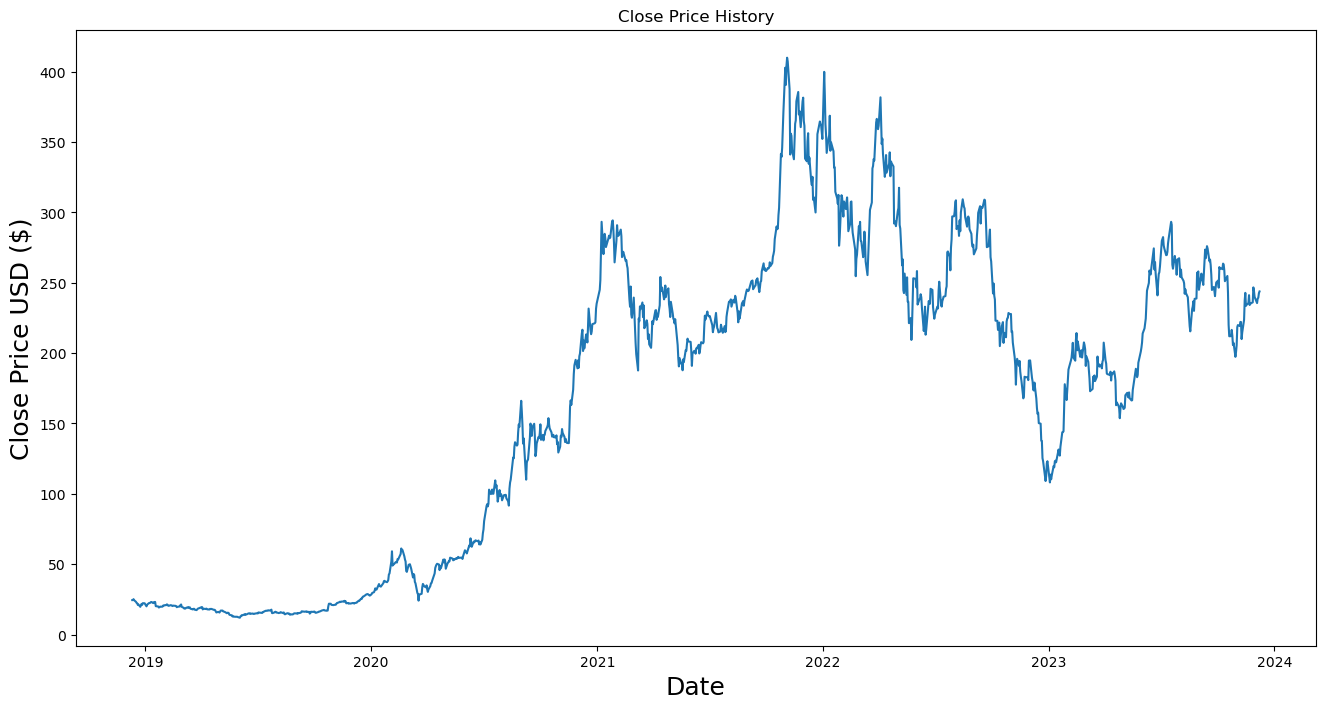

In [6]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18 )
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [7]:
# Create a dataframe with only the 'Create Column
data= df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset= data.values
# Get the number of rows to train the model on
training_data_len= math.ceil(len(dataset)* 0.80)
training_data_len

1007

In [8]:
# Scale the all of the data to be values between 0 and 1 
scaler= MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)
scaled_data

array([[0.03145255],
       [0.03142576],
       [0.03313246],
       ...,
       [0.57139841],
       [0.5796137 ],
       [0.58262848]])

In [9]:
# Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
# Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(180,len(train_data)):
    x_train.append(train_data[i-180:i,0])
    y_train.append(train_data[i,0])

    if i<=180:
      print(x_train)
      print(y_train)
      print()

[array([0.03145255, 0.03142576, 0.03313246, 0.03127669, 0.02838083,
       0.02647314, 0.02579314, 0.02284703, 0.0235823 , 0.01949894,
       0.02464082, 0.02297264, 0.02594388, 0.02576467, 0.02196604,
       0.02033136, 0.02323392, 0.02612644, 0.02619176, 0.02672437,
       0.02780299, 0.02818654, 0.02603265, 0.02771255, 0.02798388,
       0.02819491, 0.02064959, 0.02009017, 0.01819254, 0.01884909,
       0.0197753 , 0.01966476, 0.01984564, 0.02173993, 0.02144683,
       0.02231609, 0.02242998, 0.02384693, 0.02315521, 0.0215289 ,
       0.02124249, 0.02242161, 0.02224909, 0.02163944, 0.02090249,
       0.02159087, 0.02121569, 0.02069984, 0.01880219, 0.01938505,
       0.02006505, 0.01991264, 0.02273984, 0.02360072, 0.01939845,
       0.01781904, 0.0163418 , 0.01629155, 0.01635017, 0.01761471,
       0.01875027, 0.01748407, 0.018422  , 0.01858949, 0.01615589,
       0.01516101, 0.01482268, 0.01584938, 0.01591973, 0.01433026,
       0.01364189, 0.01487293, 0.01605539, 0.01669017, 0.0168

In [10]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(827, 180, 1)

In [12]:
# Build the LSTM network model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=32))
model.add(Dense(units=1))

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
827/827 [==============================] - 57s 65ms/step - loss: 0.0050
Epoch 2/20
827/827 [==============================] - 58s 70ms/step - loss: 0.0020
Epoch 3/20
827/827 [==============================] - 69s 83ms/step - loss: 0.0014
Epoch 4/20
827/827 [==============================] - 63s 76ms/step - loss: 0.0012
Epoch 5/20
827/827 [==============================] - 59s 71ms/step - loss: 0.0011
Epoch 6/20
827/827 [==============================] - 51s 61ms/step - loss: 9.3610e-04
Epoch 7/20
827/827 [==============================] - 49s 59ms/step - loss: 8.7224e-04
Epoch 8/20
827/827 [==============================] - 49s 60ms/step - loss: 8.1806e-04
Epoch 9/20
827/827 [==============================] - 52s 63ms/step - loss: 9.7222e-04
Epoch 10/20
827/827 [==============================] - 51s 61ms/step - loss: 8.5702e-04
Epoch 11/20
827/827 [==============================] - 49s 59ms/step - loss: 8.0217e-04
Epoch 12/20
827/827 [==============================] - 47s 56

In [ ]:
# Test data set
test_data = scaled_data[training_data_len - 180: , : ]
# Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(180,len(test_data)):
    x_test.append(test_data[i-180:i,0])

In [ ]:
# Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(251, 360, 1)

In [ ]:
# Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)


8/8 [==============================] - 2s 120ms/step


In [ ]:
# Convert y_test and predictions to binary (1 for increase, 0 for decrease)
y_test_direction = np.where(y_test > np.roll(y_test, 1), 1, 0)
predictions_direction = np.where(predictions > np.roll(y_test, 1), 1, 0)

In [ ]:
# Calculate accuracy
accuracy = np.mean(predictions_direction == y_test_direction)
print(f'Accuracy: {accuracy}')

Accuracy: 0.450199203187251


In [ ]:
# Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(f'RMSE: {rmse}')

RMSE: 8.349144764001926


/var/folders/p2/n5j9j_d91zx3mbjdr94kyh140000gn/T/ipykernel_9634/4118994349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


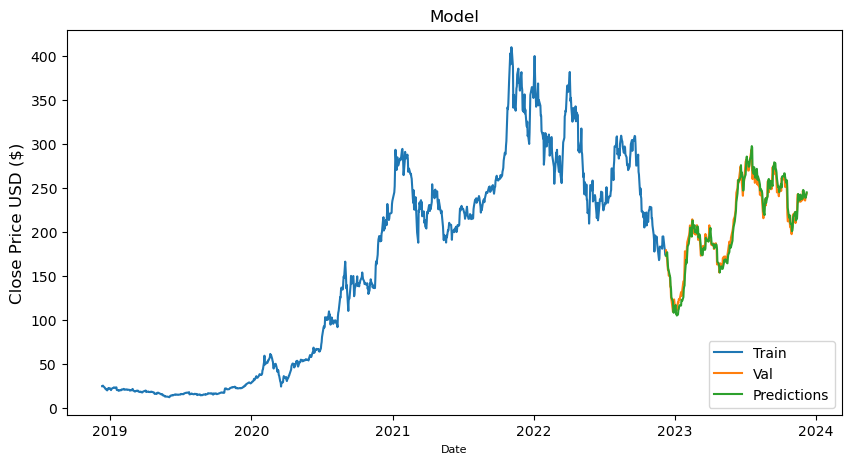

In [ ]:

# Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted price
valid

,Close,Predictions
Date,,
2022-12-09,179.050003,172.858505
2022-12-12,167.820007,176.839478
2022-12-13,160.949997,169.076004
2022-12-14,156.800003,161.696274
2022-12-15,157.669998,156.624069
...,...,...
2023-12-04,235.580002,241.623398
2023-12-05,238.720001,238.713608
2023-12-06,239.369995,241.053757
